In [59]:
import kagglehub
import torch
from torch.utils.data import WeightedRandomSampler
from torch.utils.data import DataLoader, random_split
from torchvision.models import ResNet18_Weights
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

In [60]:
path_stanford_dogs = kagglehub.dataset_download("jessicali9530/stanford-dogs-dataset")
path_wolfs = kagglehub.dataset_download("harishvutukuri/dogs-vs-wolves")

print("Path to dataset files:", path_stanford_dogs)
print("Path to dataset files:", path_wolfs)

Path to dataset files: C:\Users\Filip\.cache\kagglehub\datasets\jessicali9530\stanford-dogs-dataset\versions\2
Path to dataset files: C:\Users\Filip\.cache\kagglehub\datasets\harishvutukuri\dogs-vs-wolves\versions\2


In [61]:
print(torch.cuda.is_available())  
print(torch.version.cuda)        

True
12.4


# przeniesienie wilków do psów jako klasa (pamiętać o class imbalance)


In [62]:
import os
import shutil

# Directories
base_dir = "data"
dogs_dir = os.path.join(path_stanford_dogs, "images/images")  # Stanford Dogs 'images' folder
wolves_dir = os.path.join(path_wolfs, "data", "wolves")  # Wolves dataset directory

# Function to move wolf images into the 'images' folder
def integrate_wolves_into_dogs(dogs_dir, wolves_dir):
    """
    Moves wolf images into the 'images' directory of the dogs dataset
    under a new folder named 'wolf'.
    """
    wolf_class_dir = os.path.join(dogs_dir, "wolf")  # Target directory inside 'images'
    os.makedirs(wolf_class_dir, exist_ok=True)  # Ensure 'wolf' directory exists

    for file_name in os.listdir(wolves_dir):
        src_path = os.path.join(wolves_dir, file_name)  # Full path of the source file
        dest_path = os.path.join(wolf_class_dir, file_name)  # Full path of the destination file
        
        # Move files only (skip directories)
        if os.path.isfile(src_path):
            shutil.move(src_path, dest_path)
    
    print(f"Wolves successfully moved into: {wolf_class_dir}")

# Call the function
integrate_wolves_into_dogs(dogs_dir, wolves_dir)


Wolves successfully moved into: C:\Users\Filip\.cache\kagglehub\datasets\jessicali9530\stanford-dogs-dataset\versions\2\images/images\wolf


In [63]:


device = torch.device("cuda")


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


def prepare_dataset(dogs_dir, transform):

    dog_dataset = datasets.ImageFolder(dogs_dir, transform=transform)
    

    train_size = int(0.7 * len(dog_dataset))
    val_size = int(0.15 * len(dog_dataset))
    test_size = len(dog_dataset) - train_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dog_dataset, [train_size, val_size, test_size])

    return train_dataset, val_dataset, test_dataset



train_dataset, val_dataset, test_dataset = prepare_dataset(dogs_dir, transform)



def create_sampler(dataset):
    all_classes = range(len(dataset.dataset.classes))  
    class_names = dataset.dataset.classes  # Class names from ImageFolder

    class_counts = Counter(dataset.dataset.targets[i] for i in dataset.indices)
    
    for cls in all_classes:
        if cls not in class_counts:
            class_counts[cls] = 0  
    
    class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}  

    sample_weights = [class_weights[dataset.dataset.targets[i]] for i in dataset.indices]
    
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
    
    weight_df = pd.DataFrame({
        'Class': class_names,
        'Count': [class_counts[cls] for cls in all_classes],
        'Weight': [class_weights[cls] for cls in all_classes]
    })

    return sampler,weight_df

train_sampler,classes_weights = create_sampler(train_dataset)
train_loader = DataLoader(train_dataset, batch_size=128, sampler=train_sampler)
val_loader = DataLoader(val_dataset, batch_size=128)
test_loader = DataLoader(test_dataset, batch_size=128)


In [64]:
classes_weights

,Class,Count,Weight
0,n02085620-Chihuahua,121,0.008264
1,n02085782-Japanese_spaniel,129,0.007752
2,n02085936-Maltese_dog,182,0.005495
3,n02086079-Pekinese,103,0.009709
4,n02086240-Shih-Tzu,152,0.006579
...,...,...,...
116,n02113978-Mexican_hairless,100,0.010000
117,n02115641-dingo,112,0.008929
118,n02115913-dhole,111,0.009009
119,n02116738-African_hunting_dog,122,0.008197


In [65]:


model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
num_classes = len(train_dataset.dataset.classes) 
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)


criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20, patience=5):
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': [],
        'val_f1': []
    }
    best_f1 = 0.0
    no_improvement = 0
    best_model_path = "best_model.pth"

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")
        
        for inputs, labels in train_loop:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            train_loop.set_postfix(loss=loss.item())

        avg_train_loss = running_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        correct, total = 0, 0
        val_predictions, val_targets = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
                val_predictions.extend(preds.cpu().numpy())
                val_targets.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct / total
        f1 = f1_score(val_targets, val_predictions, average="weighted")

        history['val_loss'].append(avg_val_loss)
        history['val_accuracy'].append(val_accuracy)
        history['val_f1'].append(f1)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val F1-Score: {f1:.4f}")

        if f1 > best_f1:
            best_f1 = f1
            torch.save(model.state_dict(), best_model_path)
            no_improvement = 0
        else:
            no_improvement += 1

        if no_improvement >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    model.load_state_dict(torch.load(best_model_path, weights_only=True))
    print(f"Best Validation F1-Score: {best_f1:.4f}")
    return history


history = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10, patience=5)


Epoch 1/10: 100%|██████████| 119/119 [00:50<00:00,  2.34batch/s, loss=4.36] 


Epoch 1/10 - Train Loss: 1.9180, Val Loss: 2.5406, Val Accuracy: 0.3475, Val F1-Score: 0.3425


Epoch 2/10: 100%|██████████| 119/119 [00:48<00:00,  2.45batch/s, loss=6.04] 


Epoch 2/10 - Train Loss: 0.9097, Val Loss: 2.5112, Val Accuracy: 0.3923, Val F1-Score: 0.3802


Epoch 3/10: 100%|██████████| 119/119 [00:48<00:00,  2.44batch/s, loss=6.14] 


Epoch 3/10 - Train Loss: 0.6277, Val Loss: 1.7024, Val Accuracy: 0.5385, Val F1-Score: 0.5383


Epoch 4/10: 100%|██████████| 119/119 [00:48<00:00,  2.44batch/s, loss=5.73] 


Epoch 4/10 - Train Loss: 0.4235, Val Loss: 1.8041, Val Accuracy: 0.5236, Val F1-Score: 0.5219


Epoch 5/10: 100%|██████████| 119/119 [00:48<00:00,  2.46batch/s, loss=6.23] 


Epoch 5/10 - Train Loss: 0.3064, Val Loss: 1.8225, Val Accuracy: 0.5388, Val F1-Score: 0.5372


Epoch 6/10: 100%|██████████| 119/119 [00:48<00:00,  2.45batch/s, loss=6.94]  


Epoch 6/10 - Train Loss: 0.2388, Val Loss: 1.9393, Val Accuracy: 0.5301, Val F1-Score: 0.5288


Epoch 7/10: 100%|██████████| 119/119 [00:49<00:00,  2.42batch/s, loss=7.91]  


Epoch 7/10 - Train Loss: 0.2012, Val Loss: 1.9338, Val Accuracy: 0.5514, Val F1-Score: 0.5455


Epoch 8/10: 100%|██████████| 119/119 [00:48<00:00,  2.44batch/s, loss=6.9]   


Epoch 8/10 - Train Loss: 0.1725, Val Loss: 2.0759, Val Accuracy: 0.5323, Val F1-Score: 0.5328


Epoch 9/10: 100%|██████████| 119/119 [00:48<00:00,  2.44batch/s, loss=7.49]  


Epoch 9/10 - Train Loss: 0.1688, Val Loss: 2.0335, Val Accuracy: 0.5545, Val F1-Score: 0.5554


Epoch 10/10: 100%|██████████| 119/119 [00:49<00:00,  2.43batch/s, loss=6.62]  


Epoch 10/10 - Train Loss: 0.2161, Val Loss: 2.3761, Val Accuracy: 0.5073, Val F1-Score: 0.5045
Best Validation F1-Score: 0.5554


In [66]:
def test_model(model, test_loader):
    model.eval()
    all_predictions, all_targets = [], []
    all_probabilities = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)  
            _, preds = torch.max(outputs, 1)
            
            all_predictions.extend(preds.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
            all_probabilities.extend(probs.cpu().numpy())  


    f1 = f1_score(all_targets, all_predictions, average="weighted")


    n_classes = len(test_loader.dataset.dataset.classes)
    all_targets_one_hot = torch.nn.functional.one_hot(
        torch.tensor(all_targets), num_classes=n_classes
    ).numpy()


    auc = roc_auc_score(
        y_true=all_targets_one_hot,
        y_score=all_probabilities,  
        multi_class="ovr",
        average="weighted"
    )

    class_names = test_loader.dataset.dataset.classes  
    report = classification_report(
        all_targets,
        all_predictions,
        target_names=class_names,
        output_dict=True
    )

    report_df = pd.DataFrame(report).transpose()

    confusion = confusion_matrix(all_targets, all_predictions)
    confusion_df = pd.DataFrame(confusion, index=class_names, columns=class_names)

    print(f"Test F1-Score: {f1:.4f}, Test AUC: {auc:.4f}")

    return f1, auc, report_df, confusion_df

f1, auc, report_df, confusion_df = test_model(model, test_loader)


Testing: 100%|██████████| 26/26 [00:08<00:00,  3.23batch/s]

Test F1-Score: 0.5583, Test AUC: 0.9792


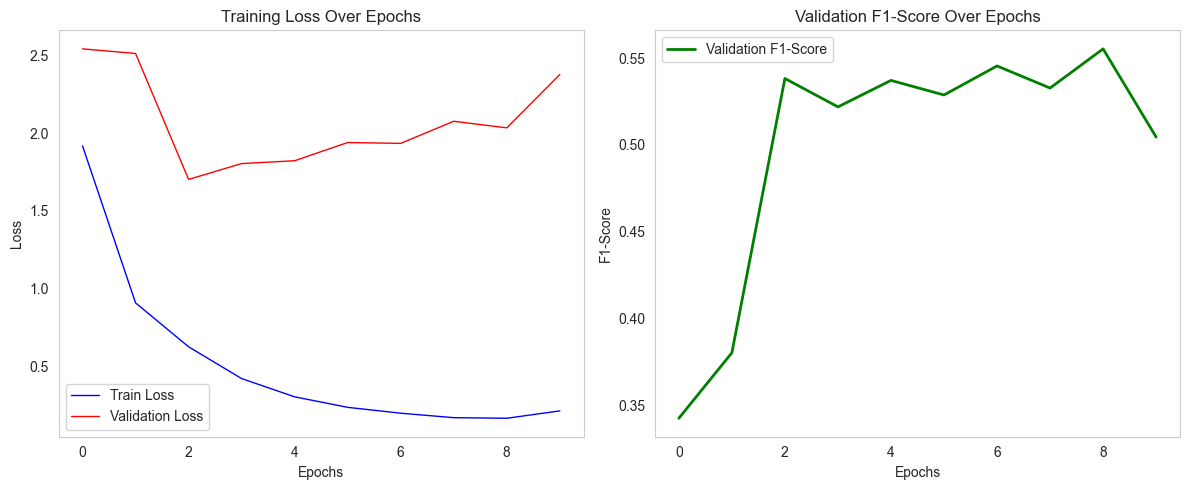

In [69]:

def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss', color='blue', linewidth=1)
    plt.plot(history['val_loss'], label='Validation Loss', color='red', linewidth=1)

    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()


    plt.subplot(1, 2, 2)
    plt.plot(history['val_f1'], label='Validation F1-Score', color='green', linewidth=2)
    plt.title('Validation F1-Score Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('F1-Score')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()
    
plot_training_history(history)

In [70]:
report_df

,precision,recall,f1-score,support
n02085620-Chihuahua,0.200000,0.142857,0.166667,14.000000
n02085782-Japanese_spaniel,0.595238,0.781250,0.675676,32.000000
n02085936-Maltese_dog,0.692308,0.514286,0.590164,35.000000
n02086079-Pekinese,0.517241,0.681818,0.588235,22.000000
n02086240-Shih-Tzu,0.367347,0.620690,0.461538,29.000000
...,...,...,...,...
n02116738-African_hunting_dog,0.764706,0.684211,0.722222,19.000000
wolf,0.920354,0.717241,0.806202,145.000000
accuracy,0.556208,0.556208,0.556208,0.556208
macro avg,0.590800,0.542794,0.540696,3238.000000
